##### Step 0: Imports, paths, reproducibility

In [1]:
import os
import random
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Dataset Paths
VREED_CSV = "dataset/vreed/EyeTracking_FeaturesExtracted.csv"
EYEGAZE_CSV = "dataset/Eye_Gaze_Classification_Dataset/EyeGaze_ImageFeatures.csv"

##### Step 1: Loading datasets

In [2]:
vreed_df = pd.read_csv(VREED_CSV)
eye_df = pd.read_csv(EYEGAZE_CSV)

print("VREED:", vreed_df.shape, "Quad_Cat:", sorted(vreed_df["Quad_Cat"].astype(str).unique()))
print("EyeGaze:", eye_df.shape, "Emotions:", sorted(eye_df["Emotion_Label"].astype(str).unique()))

VREED: (312, 50) Quad_Cat: ['0', '1', '2', '3']
EyeGaze: (23410, 513) Emotions: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


##### Step 2: Convert EyeGaze 7 emotions to VREED quadrants (0–3)

In [3]:
emotion_to_quad = {
    "happy": "0",
    "surprised": "0",

    "angry": "1",
    "fearful": "1",
    "disgusted": "1",

    "sad": "2",

    "neutral": "3",
}

eye_df["Quad_Cat"] = eye_df["Emotion_Label"].astype(str).map(emotion_to_quad)
eye_df = eye_df.dropna(subset=["Quad_Cat"]).copy()
eye_df["Quad_Cat"] = eye_df["Quad_Cat"].astype(str)

print("EyeGaze -> Quad_Cat counts:\n", eye_df["Quad_Cat"].value_counts())
print("VREED Quad_Cat counts:\n", vreed_df["Quad_Cat"].astype(str).value_counts())


EyeGaze -> Quad_Cat counts:
 Quad_Cat
0    8743
1    6720
3    4363
2    3584
Name: count, dtype: int64
VREED Quad_Cat counts:
 Quad_Cat
1    78
0    78
3    78
2    78
Name: count, dtype: int64


##### Step 3: Prepare X/y for three experiments

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def split_X_y_numeric(df, label_col):
    """
    Splits a dataframe into:
    - X: numeric feature matrix
    - y: label vector

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe
    label_col : str
        Name of label column

    Returns
    -------
    X : np.ndarray
        Numeric feature matrix
    y : np.ndarray
        Labels
    """
    # Separate labels
    y = df[label_col].values

    # Select numeric features only
    X = df.drop(columns=[label_col]).select_dtypes(include=[np.number]).values

    # Sanity checks
    assert X.shape[0] == y.shape[0], "Mismatch between X and y sizes"
    assert X.shape[1] > 0, "No numeric features found!"

    return X, y

def prepare_for_pca(X, n_components, seed=42):
    """
    Numeric selection → Imputation → Scaling → PCA
    Returns PCA-transformed data
    """
    # 1) Impute missing values
    imputer = SimpleImputer(strategy="median")
    X_imputed = imputer.fit_transform(X)

    # Sanity check
    assert not np.isnan(X_imputed).any(), "NaNs still present after imputation!"

    # 2) Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # 3) PCA
    pca = PCA(n_components=n_components, random_state=seed)
    X_pca = pca.fit_transform(X_scaled)

    return X_pca, imputer, scaler, pca

# ---- Split numeric features ----
X_vreed, y_vreed = split_X_y_numeric(vreed_df, "Quad_Cat")
X_eye,   y_eye   = split_X_y_numeric(eye_df, "Quad_Cat")

print("Raw shapes:", X_vreed.shape, X_eye.shape)

# ---- Choose common PCA dimension (≤49) ----
common_dim = min(40, X_vreed.shape[1])

# ---- Apply preprocessing + PCA ----
X_vreed_pca, imp_v, sc_v, pca_v = prepare_for_pca(X_vreed, common_dim, SEED)
X_eye_pca,   imp_e, sc_e, pca_e = prepare_for_pca(X_eye,   common_dim, SEED)

print("After PCA:")
print("VREED PCA:", X_vreed_pca.shape)
print("EyeGaze PCA:", X_eye_pca.shape)

# ---- Fusion (NOW SAFE) ----
X_fusion = np.vstack([X_vreed_pca, X_eye_pca])
y_fusion = np.concatenate([y_vreed, y_eye])

print("Fusion:", X_fusion.shape, y_fusion.shape)


Raw shapes: (312, 49) (23410, 512)
After PCA:
VREED PCA: (312, 40)
EyeGaze PCA: (23410, 40)
Fusion: (23722, 40) (23722,)


##### Step 4 — Encode labels (Quadrants 0–3)

In [7]:
from sklearn.preprocessing import LabelEncoder

le_quad = LabelEncoder()
y_vreed_enc = le_quad.fit_transform(y_vreed)   # VREED quadrants
y_eye_enc   = le_quad.transform(y_eye)         # EyeGaze mapped quadrants (must be same labels)
y_fusion_enc = le_quad.transform(y_fusion)

print("Quadrant classes:", list(le_quad.classes_))

Quadrant classes: [0, 1, 2, 3]


##### Step 5 — Define models (same three, tuned + stable)

In [8]:
def get_models(seed=42):
    return {
        "Random Forest": RandomForestClassifier(n_estimators=400, random_state=seed),
        "SVM (RBF)": SVC(kernel="rbf", C=5, gamma="scale", random_state=seed),
        "MLP": MLPClassifier(hidden_layer_sizes=(256,128,64), max_iter=600, random_state=seed)
    }

##### Step 6 — Research-grade evaluation: 5-Fold Stratified CV

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

def run_cv(X, y, setting_name, n_splits=5, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    models = get_models(seed)

    results = []
    last_fold_preds = {}  # save final fold for confusion matrix

    for model_name in models:
        accs, f1s = [], []

        for fold, (tr, te) in enumerate(skf.split(X, y), start=1):
            Xtr, Xte = X[tr], X[te]
            ytr, yte = y[tr], y[te]

            clf = models[model_name]
            clf.fit(Xtr, ytr)
            pred = clf.predict(Xte)

            accs.append(accuracy_score(yte, pred))
            f1s.append(f1_score(yte, pred, average="weighted"))

            if fold == n_splits:
                last_fold_preds[model_name] = (yte, pred)

        results.append({
            "Setting": setting_name,
            "Model": model_name,
            "Accuracy_mean": np.mean(accs),
            "Accuracy_std": np.std(accs),
            "F1_mean": np.mean(f1s),
            "F1_std": np.std(f1s),
        })

    return pd.DataFrame(results), last_fold_preds


##### Step 7 — Run three main experiments

In [10]:
res_vreed, pred_vreed = run_cv(X_vreed_pca, y_vreed_enc, "VREED Only (4-class)")
res_eye,   pred_eye   = run_cv(X_eye_pca,   y_eye_enc,   "EyeGaze Only (4-class)")
res_fus,   pred_fus   = run_cv(X_fusion,    y_fusion_enc,"Fusion (VREED + EyeGaze)")

results_all = pd.concat([res_vreed, res_eye, res_fus], ignore_index=True)
print(results_all.sort_values(["Setting","Accuracy_mean"], ascending=[True, False]))


                    Setting          Model  Accuracy_mean  Accuracy_std  \
3    EyeGaze Only (4-class)  Random Forest       0.471551      0.003237   
4    EyeGaze Only (4-class)      SVM (RBF)       0.458736      0.004436   
5    EyeGaze Only (4-class)            MLP       0.426869      0.007424   
6  Fusion (VREED + EyeGaze)  Random Forest       0.471966      0.006688   
7  Fusion (VREED + EyeGaze)      SVM (RBF)       0.457845      0.004686   
8  Fusion (VREED + EyeGaze)            MLP       0.419020      0.002443   
2      VREED Only (4-class)            MLP       0.644342      0.043432   
1      VREED Only (4-class)      SVM (RBF)       0.593190      0.052138   
0      VREED Only (4-class)  Random Forest       0.576907      0.032937   

    F1_mean    F1_std  
3  0.416306  0.003085  
4  0.422174  0.004900  
5  0.424902  0.007362  
6  0.416926  0.005521  
7  0.421331  0.005221  
8  0.417668  0.003298  
2  0.642361  0.041931  
1  0.591984  0.050596  
0  0.574589  0.034293  


##### Step 8 — mean±std Accuracy + confusion matrix of best fusion model

In [11]:
best_fusion_row = res_fus.sort_values("Accuracy_mean", ascending=False).iloc[0]
best_model_name = best_fusion_row["Model"]
print("Best Fusion Model:", best_model_name)

y_true_last, y_pred_last = pred_fus[best_model_name]
cm = confusion_matrix(y_true_last, y_pred_last)

Best Fusion Model: Random Forest


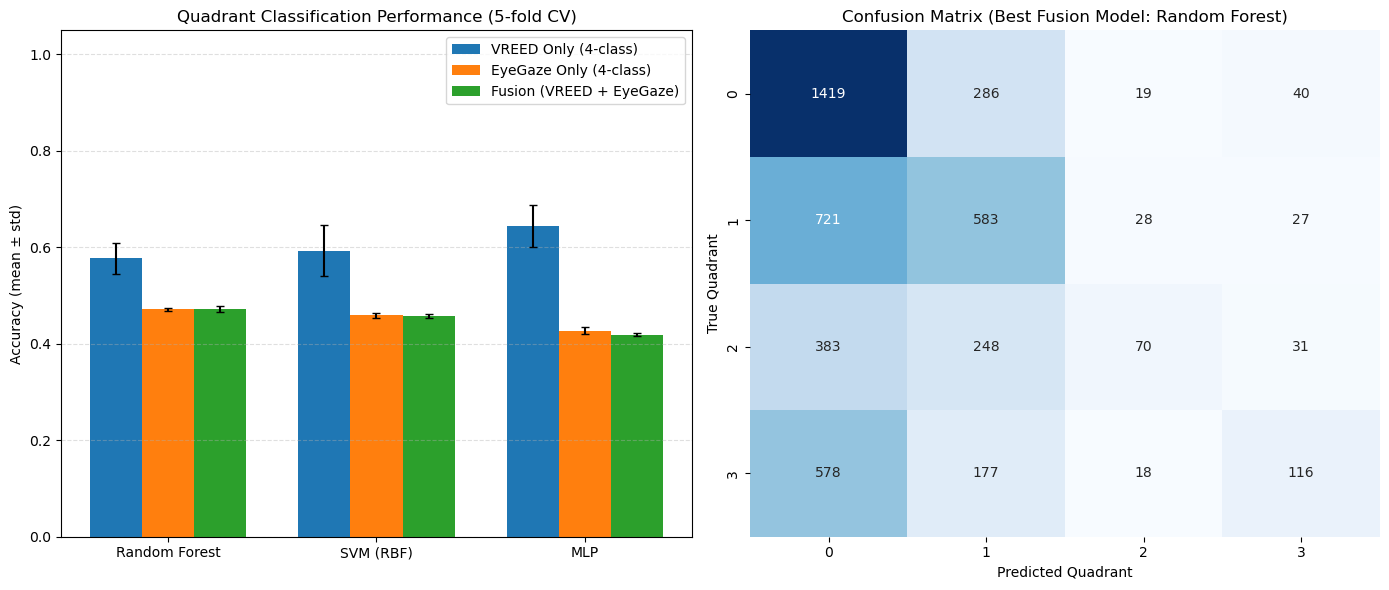

In [12]:
# Build accuracy comparison table for plotting
plot_df = results_all.copy()
order_models = ["Random Forest", "SVM (RBF)", "MLP"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left panel: Accuracy mean ± std for each setting
settings = ["VREED Only (4-class)", "EyeGaze Only (4-class)", "Fusion (VREED + EyeGaze)"]
x = np.arange(len(order_models))
width = 0.25

for i, setting in enumerate(settings):
    sub = plot_df[plot_df["Setting"] == setting].set_index("Model").loc[order_models]
    axes[0].bar(
        x + (i-1)*width,
        sub["Accuracy_mean"].values,
        width,
        yerr=sub["Accuracy_std"].values,
        capsize=3,
        label=setting
    )

axes[0].set_xticks(x)
axes[0].set_xticklabels(order_models)
axes[0].set_ylim(0, 1.05)
axes[0].set_ylabel("Accuracy (mean ± std)")
axes[0].set_title("Quadrant Classification Performance (5-fold CV)")
axes[0].grid(axis="y", linestyle="--", alpha=0.4)
axes[0].legend()

# --- Right panel: Confusion matrix for best fusion model ---
labels = list(le_quad.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title(f"Confusion Matrix (Best Fusion Model: {best_model_name})")
axes[1].set_xlabel("Predicted Quadrant")
axes[1].set_ylabel("True Quadrant")

plt.tight_layout()
plt.show()


##### Step 9 — Explainability (Permutation importance for RF on fusion)

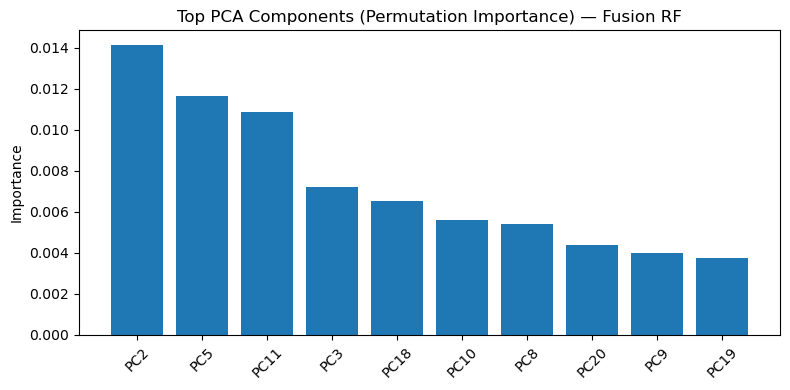

In [14]:
from sklearn.model_selection import train_test_split

# Train-test split just for explainability (not for reporting final performance)
Xtr, Xte, ytr, yte = train_test_split(
    X_fusion, y_fusion_enc, test_size=0.2, random_state=SEED, stratify=y_fusion_enc
)

rf_explain = RandomForestClassifier(n_estimators=400, random_state=SEED)
rf_explain.fit(Xtr, ytr)

perm = permutation_importance(rf_explain, Xte, yte, n_repeats=10, random_state=SEED)
top = np.argsort(perm.importances_mean)[::-1][:10]

plt.figure(figsize=(8,4))
plt.bar(range(10), perm.importances_mean[top])
plt.xticks(range(10), [f"PC{i+1}" for i in top], rotation=45)
plt.title("Top PCA Components (Permutation Importance) — Fusion RF")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

##### Step 10A — CORAL ablation (Fusion: No Adapt vs CORAL)

##### 10.1 CORAL function (stable)

In [15]:
def cov_mat(X):
    Xc = X - X.mean(axis=0, keepdims=True)
    return (Xc.T @ Xc) / max(1, (Xc.shape[0] - 1))

def sqrtm_psd(A, eps=1e-6):
    vals, vecs = np.linalg.eigh(A)
    vals = np.clip(vals, eps, None)
    return (vecs * np.sqrt(vals)) @ vecs.T

def invsqrtm_psd(A, eps=1e-6):
    vals, vecs = np.linalg.eigh(A)
    vals = np.clip(vals, eps, None)
    return (vecs * (1.0 / np.sqrt(vals))) @ vecs.T

def coral_align(Xs, Xt, eps=1e-6):
    # Align source -> target in feature space
    Cs = cov_mat(Xs) + eps * np.eye(Xs.shape[1])
    Ct = cov_mat(Xt) + eps * np.eye(Xt.shape[1])
    A = invsqrtm_psd(Cs, eps) @ sqrtm_psd(Ct, eps)
    return (Xs - Xs.mean(axis=0, keepdims=True)) @ A + Xt.mean(axis=0, keepdims=True)


##### 10.2 CV runner that returns fold scores (needed for significance tests)

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

def run_cv_with_folds_fusion(X_fusion, y_fusion, n_vreed, setting_name, use_coral=False, n_splits=5, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    models = get_models(seed)

    fold_scores = {m: {"acc": [], "f1": []} for m in models}
    last_fold_preds = {}

    for model_name, clf in models.items():
        for fold, (tr, te) in enumerate(skf.split(X_fusion, y_fusion), start=1):
            Xtr, Xte = X_fusion[tr], X_fusion[te]
            ytr, yte = y_fusion[tr], y_fusion[te]

            if use_coral:
                # domain labels on TRAIN fold
                dtr = (tr >= n_vreed).astype(int)  # 0=VREED, 1=EyeGaze
                Xtr_v = Xtr[dtr == 0]
                Xtr_e = Xtr[dtr == 1]

                # Only align if both sides have enough samples
                if len(Xtr_v) > 5 and len(Xtr_e) > 5:
                    Xtr_e_aligned = coral_align(Xtr_e, Xtr_v)
                    Xtr2 = Xtr.copy()
                    Xtr2[dtr == 1] = Xtr_e_aligned
                    Xtr = Xtr2

            clf.fit(Xtr, ytr)
            pred = clf.predict(Xte)

            acc = accuracy_score(yte, pred)
            f1 = f1_score(yte, pred, average="weighted")

            fold_scores[model_name]["acc"].append(acc)
            fold_scores[model_name]["f1"].append(f1)

            if fold == n_splits:
                last_fold_preds[model_name] = (yte, pred)

        print(f"[{setting_name}] {model_name} done.")

    return fold_scores, last_fold_preds


##### 10.3 Run fusion CV twice: No Adapt vs CORAL

In [17]:
n_vreed = X_vreed_pca.shape[0]

fold_no, pred_no = run_cv_with_folds_fusion(
    X_fusion, y_fusion_enc, n_vreed,
    setting_name="Fusion (No Adapt)", use_coral=False, n_splits=5, seed=SEED
)

fold_coral, pred_coral = run_cv_with_folds_fusion(
    X_fusion, y_fusion_enc, n_vreed,
    setting_name="Fusion (CORAL)", use_coral=True, n_splits=5, seed=SEED
)


[Fusion (No Adapt)] Random Forest done.
[Fusion (No Adapt)] SVM (RBF) done.
[Fusion (No Adapt)] MLP done.
[Fusion (CORAL)] Random Forest done.
[Fusion (CORAL)] SVM (RBF) done.
[Fusion (CORAL)] MLP done.


##### Paired t-test and Wilcoxon signed-rank test

In [18]:
from scipy.stats import ttest_rel, wilcoxon

for model in fold_no:
    acc_no = np.array(fold_no[model]["acc"])
    acc_coral = np.array(fold_coral[model]["acc"])

    t_stat, p_t = ttest_rel(acc_coral, acc_no)
    w_stat, p_w = wilcoxon(acc_coral - acc_no)

    print(f"{model}: t-test p={p_t:.4f}, Wilcoxon p={p_w:.4f}")


Random Forest: t-test p=0.0002, Wilcoxon p=0.0625
SVM (RBF): t-test p=0.0013, Wilcoxon p=0.0625
MLP: t-test p=0.0002, Wilcoxon p=0.0625


##### Step 11 — CORAL ablation summary table (mean ± std)

In [19]:
def summarize_fold_scores(fold_scores, setting_name):
    rows = []
    for model_name in fold_scores:
        acc = np.array(fold_scores[model_name]["acc"])
        f1  = np.array(fold_scores[model_name]["f1"])
        rows.append({
            "Setting": setting_name,
            "Model": model_name,
            "Acc_mean": acc.mean(),
            "Acc_std": acc.std(),
            "F1_mean": f1.mean(),
            "F1_std": f1.std()
        })
    return pd.DataFrame(rows)

sum_no = summarize_fold_scores(fold_no, "Fusion (No Adapt)")
sum_c  = summarize_fold_scores(fold_coral, "Fusion (CORAL)")

ablation_table = pd.concat([sum_no, sum_c], ignore_index=True)
print(ablation_table.sort_values(["Model", "Setting"]))


             Setting          Model  Acc_mean   Acc_std   F1_mean    F1_std
5     Fusion (CORAL)            MLP  0.376022  0.005032  0.375029  0.004001
2  Fusion (No Adapt)            MLP  0.419020  0.002443  0.417668  0.003298
3     Fusion (CORAL)  Random Forest  0.416997  0.005248  0.381075  0.005071
0  Fusion (No Adapt)  Random Forest  0.471966  0.006688  0.416926  0.005521
4     Fusion (CORAL)      SVM (RBF)  0.414762  0.010744  0.400238  0.011840
1  Fusion (No Adapt)      SVM (RBF)  0.457845  0.004686  0.421331  0.005221


##### Step 12 — Fusion No Adapt vs CORAL + Confusion matrix

Best model (CORAL): Random Forest


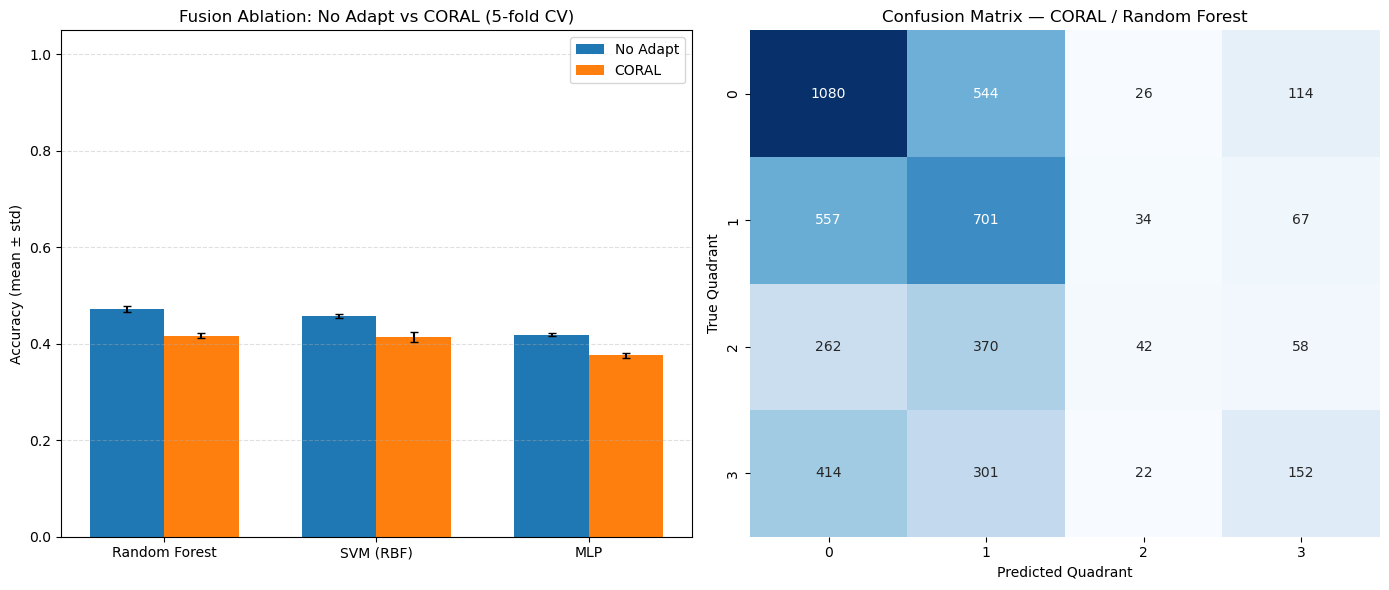

In [21]:
# pick best model by CORAL accuracy mean
best_model = sum_c.sort_values("Acc_mean", ascending=False).iloc[0]["Model"]
print("Best model (CORAL):", best_model)

# confusion matrix from last fold
y_true, y_pred = pred_coral[best_model]
cm = confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

models_order = ["Random Forest", "SVM (RBF)", "MLP"]
x = np.arange(len(models_order))
w = 0.35

acc_no = sum_no.set_index("Model").loc[models_order]["Acc_mean"].values
acc_co = sum_c.set_index("Model").loc[models_order]["Acc_mean"].values

std_no = sum_no.set_index("Model").loc[models_order]["Acc_std"].values
std_co = sum_c.set_index("Model").loc[models_order]["Acc_std"].values

axes[0].bar(x - w/2, acc_no, w, yerr=std_no, capsize=3, label="No Adapt")
axes[0].bar(x + w/2, acc_co, w, yerr=std_co, capsize=3, label="CORAL")
axes[0].set_title("Fusion Ablation: No Adapt vs CORAL (5-fold CV)")
axes[0].set_ylabel("Accuracy (mean ± std)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_order)
axes[0].set_ylim(0, 1.05)
axes[0].grid(axis="y", linestyle="--", alpha=0.4)
axes[0].legend()

labels = list(le_quad.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1],
            xticklabels=labels, yticklabels=labels)
axes[1].set_title(f"Confusion Matrix — CORAL / {best_model}")
axes[1].set_xlabel("Predicted Quadrant")
axes[1].set_ylabel("True Quadrant")

plt.tight_layout()
plt.show()
